In [1]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pywph as pw
import numpy as np
import torch
from sklearn.utils.extmath import svd_flip

Reason for being yanked: Wrong requirements.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas_file = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')
#wph_coeffs_1000 = pd.read_csv('drive/MyDrive/camels data/wph_coeffs_1000.csv')

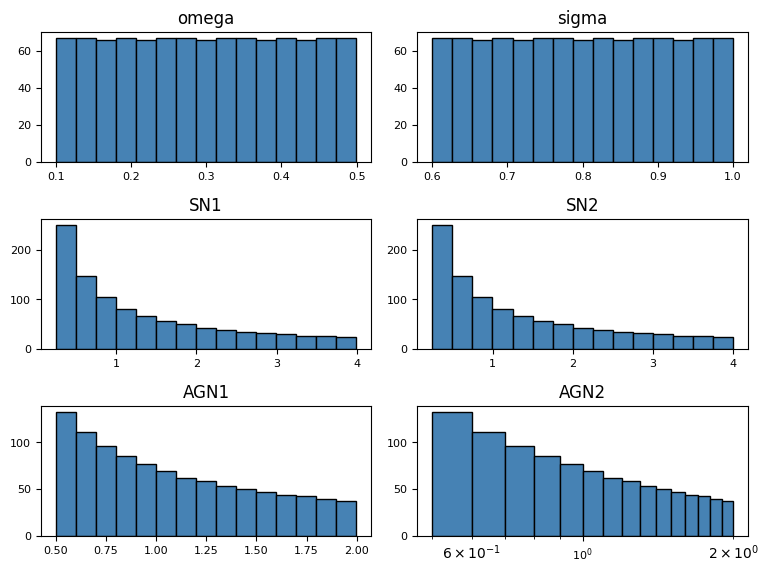

In [4]:
# parameters
params.hist(bins=15, color='steelblue',edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8,grid=False)
plt.tight_layout(rect=(0,0, 1.2, 1.2))
plt.xscale('log')

In [5]:
def PCA(data, num_components):
    """calculate the principal components"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)
    U,V = svd_flip(U,V) # flip sign to enforce deterministic output

    # project onto the new space
    data_transformed = data_standard.dot(V[:num_components].T)
    data_reduced = U[:,:num_components]*S[:num_components]

    return data_reduced

def PCA_weight(data, num_components):
    """calculate the weighting of each WPH coefficient"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)
    U,V = svd_flip(U,V) # flip sign to enforce deterministic output

    return V[:2]

def PCA_explained_variance_ratio(data, num_components):
    """calculate the explained_variance_ratio"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)

    n_data, n_features = data.shape
    explained_variance_ = (S**2)/(n_data - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio = explained_variance_/total_var

    return explained_variance_ratio[:2]

In [6]:
nbody = np.copy(nbody_file[0])
nbody_data = np.log(nbody)

mgas = np.copy(mgas_file[0])
mgas_data = np.log(mgas)

In [7]:
M = 256
N = 256
J = 7
L = 4
dn =0

wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)
wph_op.load_model(cross_moments=True)
joint_coeff = wph_op([nbody_data, mgas_data], cross=True, pbc=True)

if torch.cuda.is_available():
    wph_op.to(0)

In [8]:
# cross coeff: "S11", "S00", "C00", "S01", "C01", "S10", "C10", "Cphase", "Cphase_inv", "L"

In [9]:
wph = wph_op([nbody_data, mgas_data], cross=True, ret_wph_obj=True, norm=None)
S11_shape = (wph.get_coeffs("S11")[0].shape)[0]
S00_shape = (wph.get_coeffs("S00")[0].shape)[0]
C00_shape = (wph.get_coeffs("C00")[0].shape)[0]
S01_shape = (wph.get_coeffs("S01")[0].shape)[0]
C01_shape = (wph.get_coeffs("C01")[0].shape)[0]
S10_shape = (wph.get_coeffs("S10")[0].shape)[0]
C10_shape = (wph.get_coeffs("C10")[0].shape)[0]
Cphase_shape = (wph.get_coeffs("Cphase")[0].shape)[0]
Cphase_inv_shape = (wph.get_coeffs("Cphase_inv")[0].shape)[0]
L_shape = (wph.get_coeffs("L")[0].shape)[0]


In [10]:
num = 1000
nbody_data = np.log(nbody_file)
mgas_data = np.log(mgas_file)
wph_joint_coeffs_1000 = np.zeros((num,968), dtype='complex')

for i in range(0,num):
  if i%50==0: print(i)
  joint_coeff = wph_op([nbody_data[(i*15):(i*15+15)], mgas_data[(i*15):(i*15+15)]], cross=True, pbc=True, norm=None)
  wph_joint_coeffs_1000[i] = joint_coeff.mean(axis=0).cpu()


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [11]:
#wph_joint_coeffs_1000 = pd.DataFrame(wph_joint_coeffs_1000)

In [12]:
#wph_joint_coeffs_1000

In [13]:
PCA_explained_variance_ratio(wph_joint_coeffs_1000,2)

array([0.99620393, 0.00338613])

In [14]:
joint_pcs = PCA(wph_joint_coeffs_1000,2)

Text(0, 0.5, 'component 2')

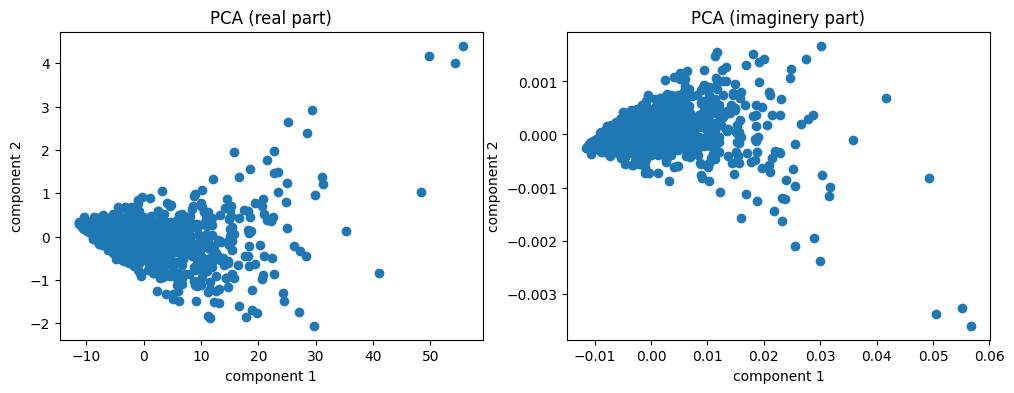

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter((joint_pcs[:,0]).real,(joint_pcs[:,1]).real)
axs[1].scatter((joint_pcs[:,0]).imag,(joint_pcs[:,1]).imag)

axs[0].set_title('PCA (real part)')
axs[1].set_title('PCA (imaginery part)')

axs[0].set_xlabel('component 1')
axs[0].set_ylabel('component 2')
axs[1].set_xlabel('component 1')
axs[1].set_ylabel('component 2')

PC1

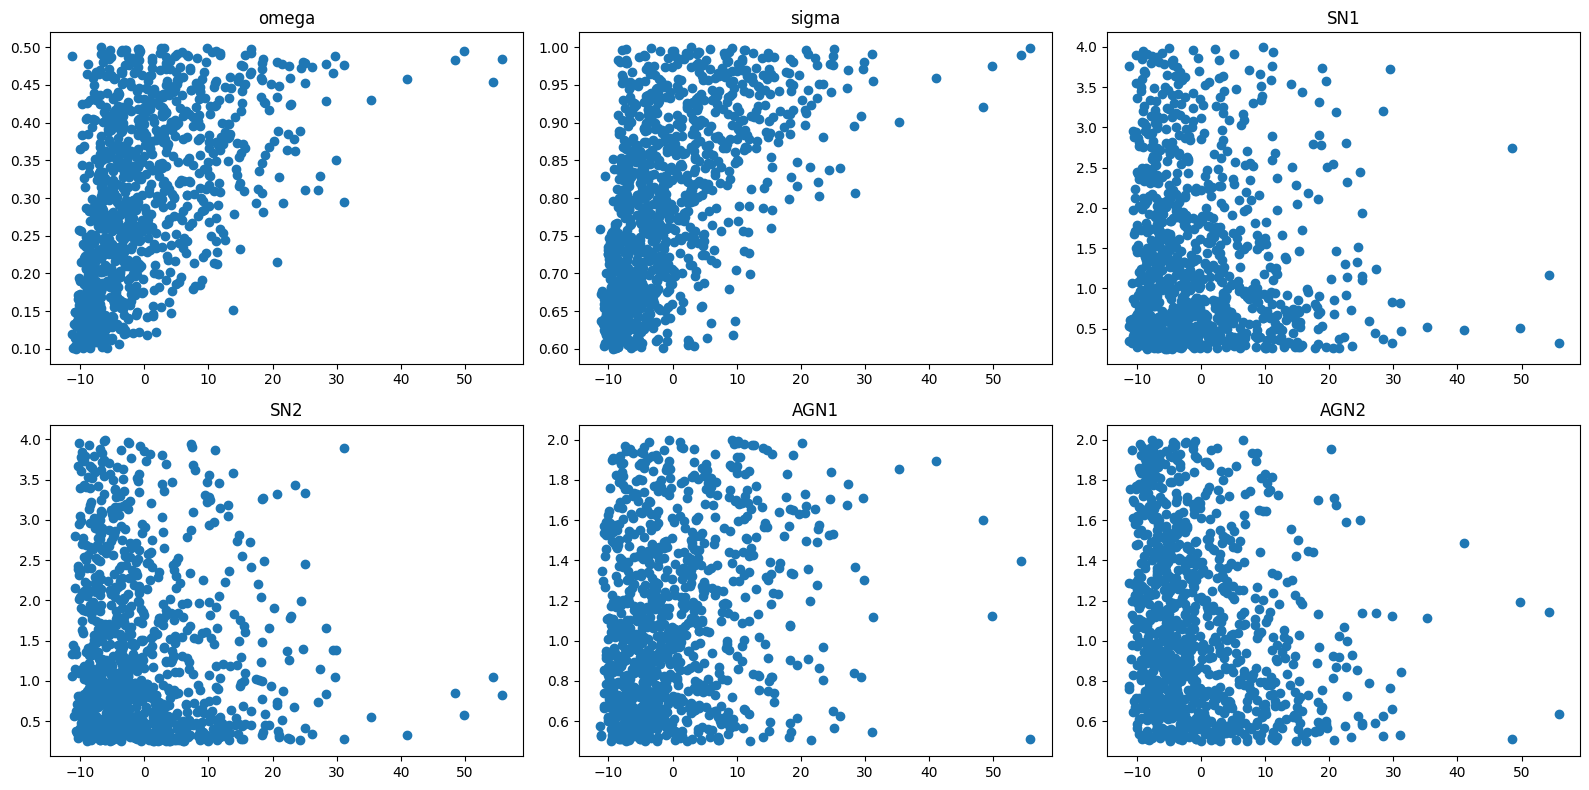

In [16]:
# pc1 real part
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

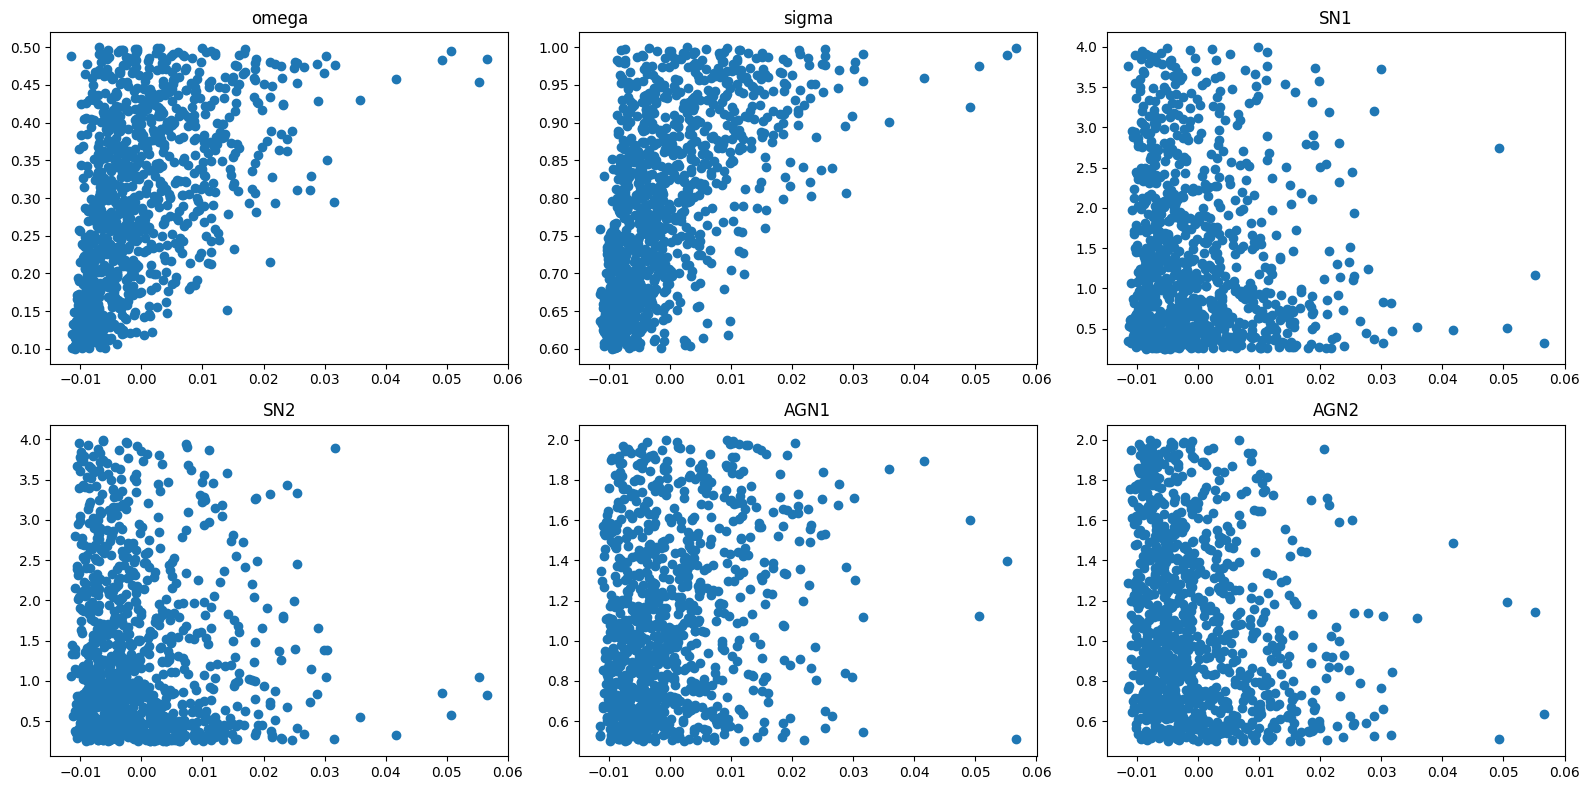

In [17]:
# pc1 imag part
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs[:,0]).imag,params['omega'])
axs[0,1].scatter((joint_pcs[:,0]).imag,params['sigma'])
axs[0,2].scatter((joint_pcs[:,0]).imag,params['SN1'])
axs[1,0].scatter((joint_pcs[:,0]).imag,params['SN2'])
axs[1,1].scatter((joint_pcs[:,0]).imag,params['AGN1'])
axs[1,2].scatter((joint_pcs[:,0]).imag,params['AGN2'])


fig.tight_layout()
fig.show()

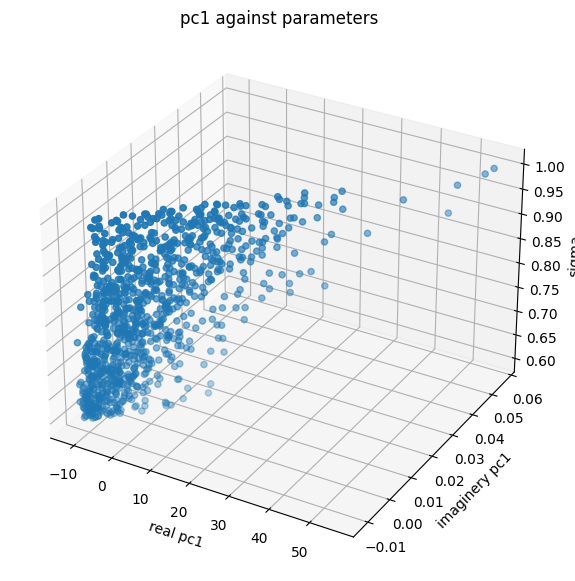

In [18]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D((joint_pcs[:,0]).real, (joint_pcs[:,0]).imag, params['sigma'])
ax.set_xlabel('real pc1')
ax.set_ylabel('imaginery pc1')
ax.set_zlabel('sigma')
plt.title("pc1 against parameters")
plt.show()

In [19]:
s11_pos = S11_shape
s00_pos = S11_shape + S00_shape
c00_pos = S11_shape + S00_shape + C00_shape
s01_pos = S11_shape + S00_shape + C00_shape + S01_shape
c01_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape
s10_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape
c10_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape
cphase_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape
cphase_inv_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape + Cphase_inv_shape
l_pos = S11_shape + S00_shape + C00_shape + S01_shape + C01_shape + S10_shape + C10_shape + Cphase_shape + Cphase_inv_shape + L_shape

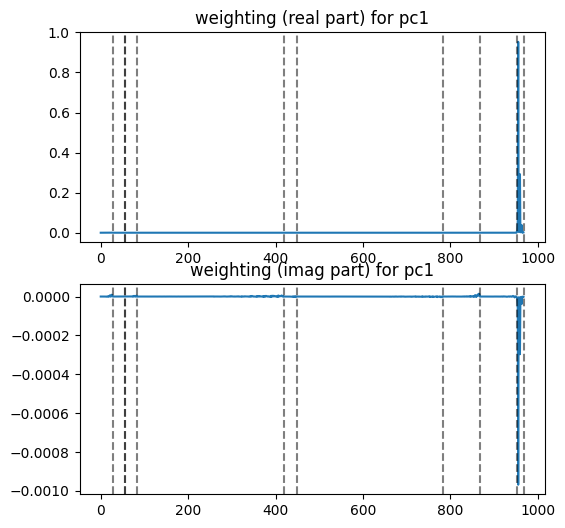

In [20]:
# weight for pc1
joint_weight1 = PCA_weight(wph_joint_coeffs_1000, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight1.real)
axs[1].plot(joint_weight1.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


### if we remove L

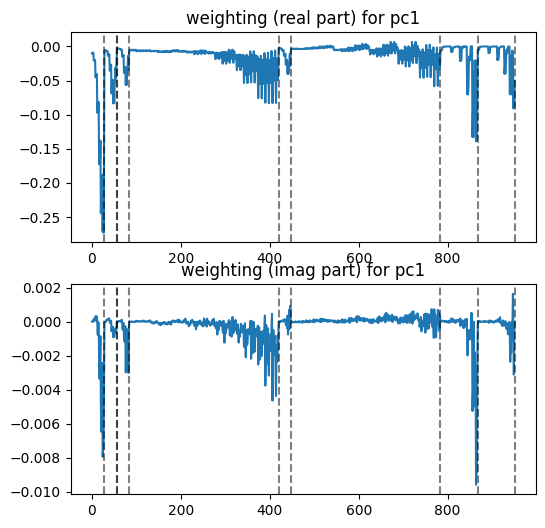

In [21]:
wph_joint_coeffs_900 = wph_joint_coeffs_1000[:,:cphase_inv_pos]

joint_weight0 = PCA_weight(wph_joint_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight0.real)
axs[1].plot(joint_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  #axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


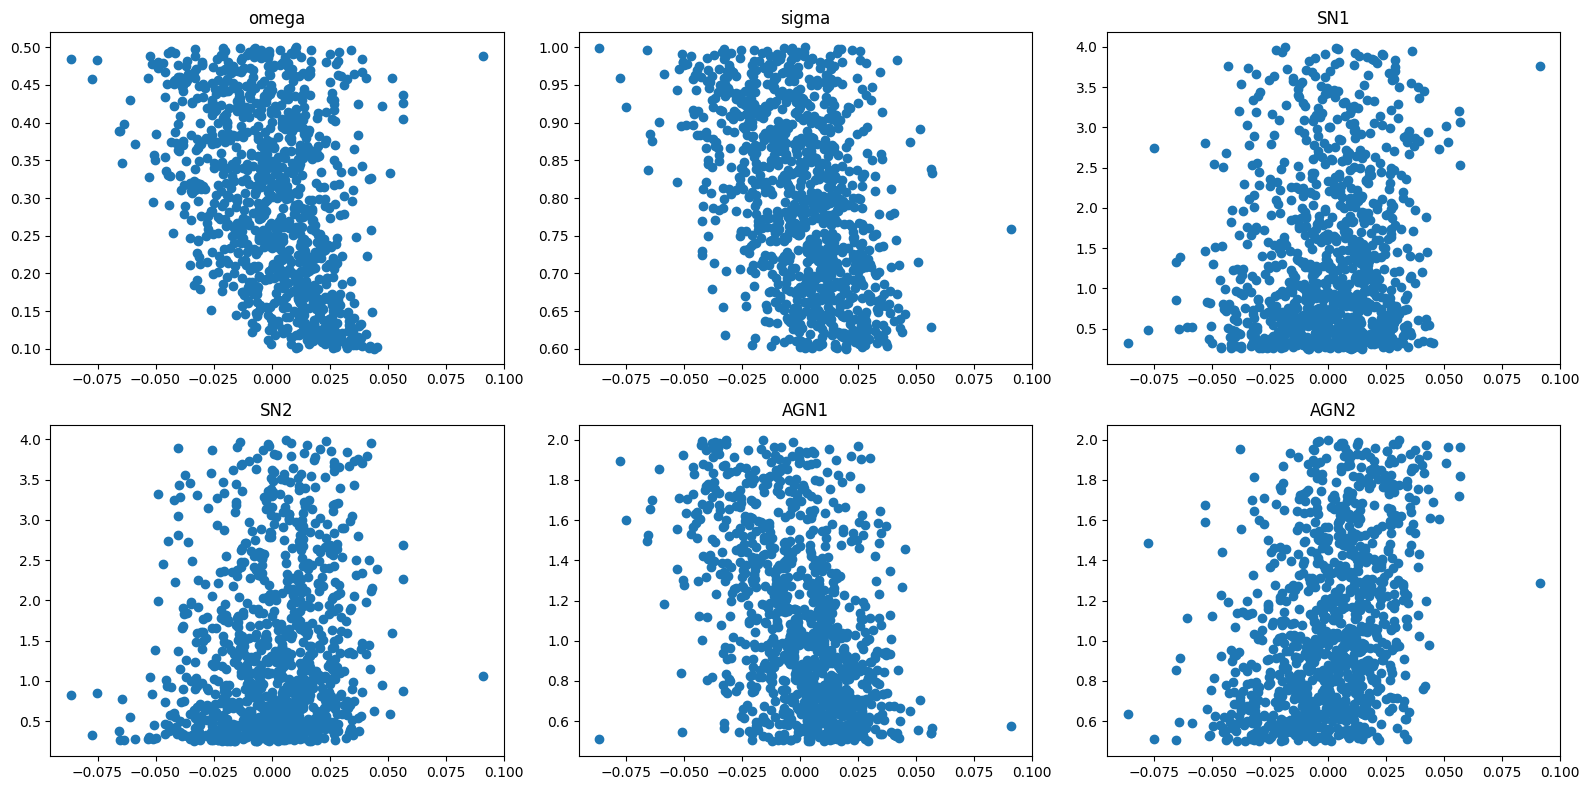

In [22]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs_900[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

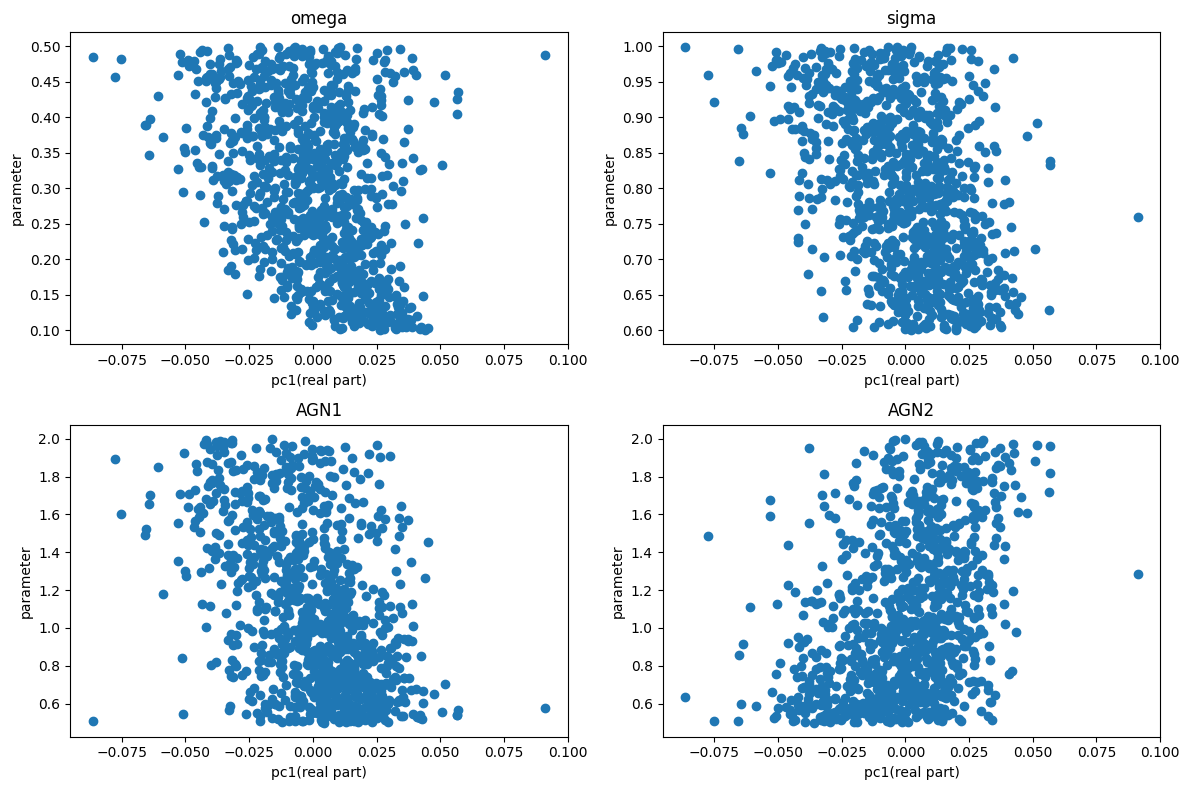

In [23]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[1,0].set_title('AGN1')
axs[1,1].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN2'])

for i in range(0,2):
  for j in range(0,2):
    axs[i,j].set_xlabel('pc1(real part)')
    axs[i,j].set_ylabel('parameter')

fig.tight_layout()
fig.show()

### if we also remove s11

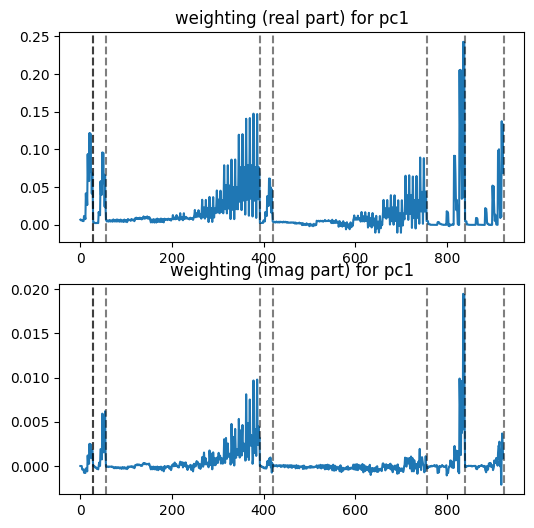

In [24]:
wph_joint_coeffs_900 = wph_joint_coeffs_1000[:,s11_pos:cphase_inv_pos]

joint_weight0 = PCA_weight(wph_joint_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(joint_weight0.real)
axs[1].plot(joint_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  #axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)


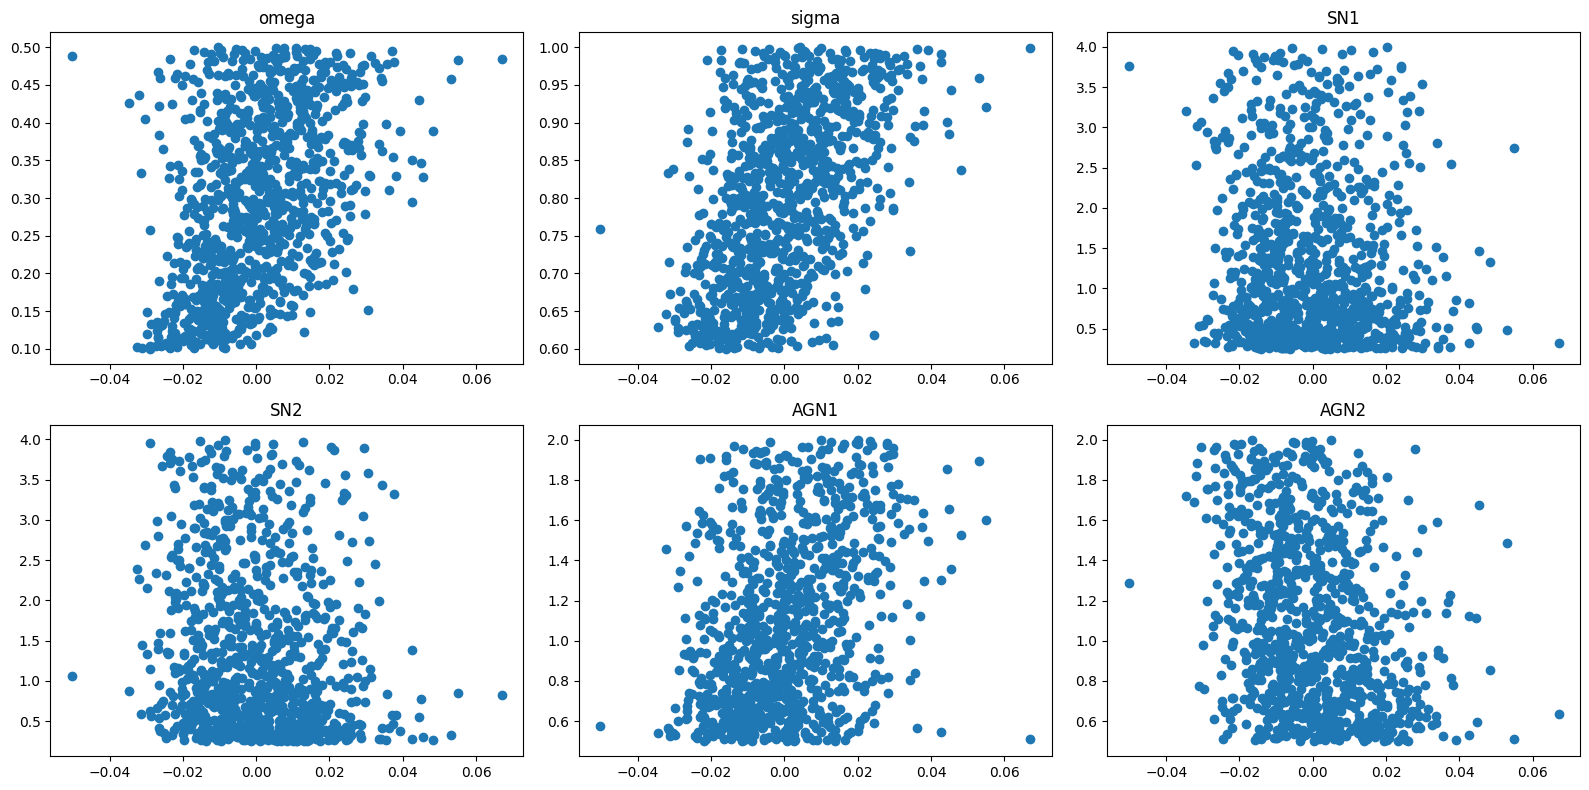

In [25]:
# pc1 real part
joint_pcs_900 = PCA(wph_joint_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((joint_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((joint_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((joint_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((joint_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((joint_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((joint_pcs_900[:,0]).real,params['AGN2'])

fig.tight_layout()
fig.show()

### use normalisation = 'auto' instead of 'None'

In [26]:
num = 1000
nbody_data = np.log(nbody_file)
mgas_data = np.log(mgas_file)
wph_norm_coeffs_1000 = np.zeros((num,968), dtype='complex')
wph = wph_op([nbody_data[0:(15)], mgas_data[:(15)]], cross=True, pbc=True, norm='auto', ret_wph_obj=True)

for i in range(0,num):
  if i%50==0: print(i)
  joint_coeff = wph_op.apply([nbody_data[(i*15):(i*15+15)], mgas_data[(i*15):(i*15+15)]], cross=True, pbc=True, norm='auto')
  wph_norm_coeffs_1000[i] = joint_coeff.mean(axis=0).cpu()


0


/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [27]:
#wph_norm_coeffs_1000 = pd.DataFrame(wph_norm_coeffs_1000)

In [29]:
PCA_explained_variance_ratio(wph_norm_coeffs_1000,2)

array([0.99734597, 0.00190311])

In [30]:
norm_pcs = PCA(wph_norm_coeffs_1000,2)

In [31]:
norm_pcs.shape

(1000, 2)

Text(0, 0.5, 'component 2')

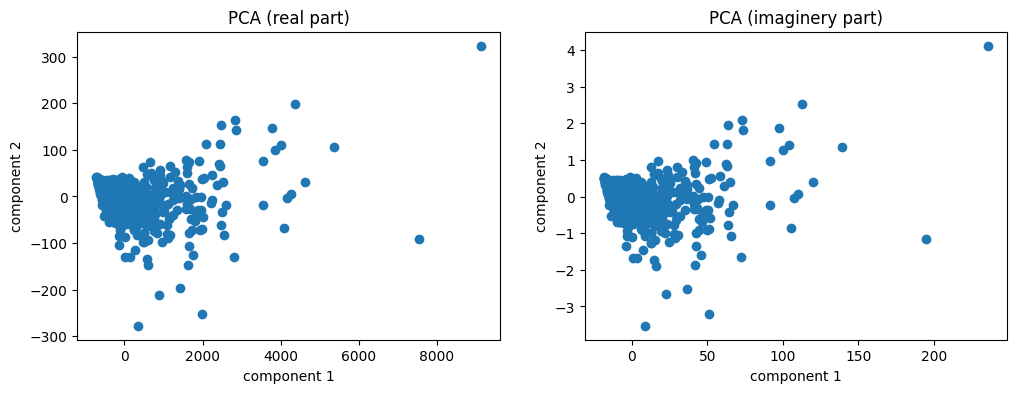

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter((norm_pcs[:,0]).real,(norm_pcs[:,1]).real)
axs[1].scatter((norm_pcs[:,0]).imag,(norm_pcs[:,1]).imag)

axs[0].set_title('PCA (real part)')
axs[1].set_title('PCA (imaginery part)')

axs[0].set_xlabel('component 1')
axs[0].set_ylabel('component 2')
axs[1].set_xlabel('component 1')
axs[1].set_ylabel('component 2')

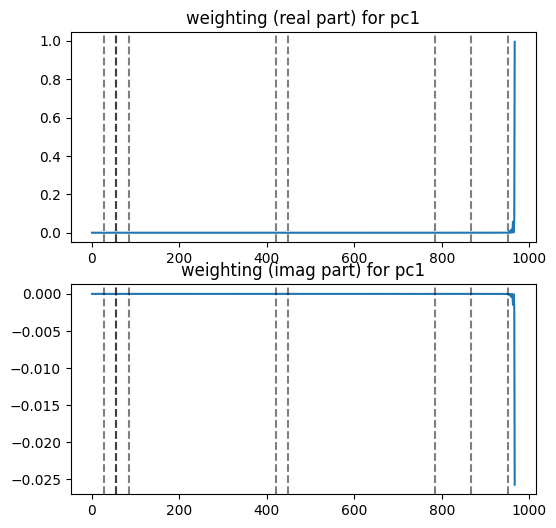

In [33]:
# weighting
norm_weight = PCA_weight(wph_norm_coeffs_1000, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(norm_weight.real)
axs[1].plot(norm_weight.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos, linestyle='dashed', color='black', alpha=0.5)
  #axs[i].axvline(l_pos, linestyle='dashed', color='black', alpha=0.5)


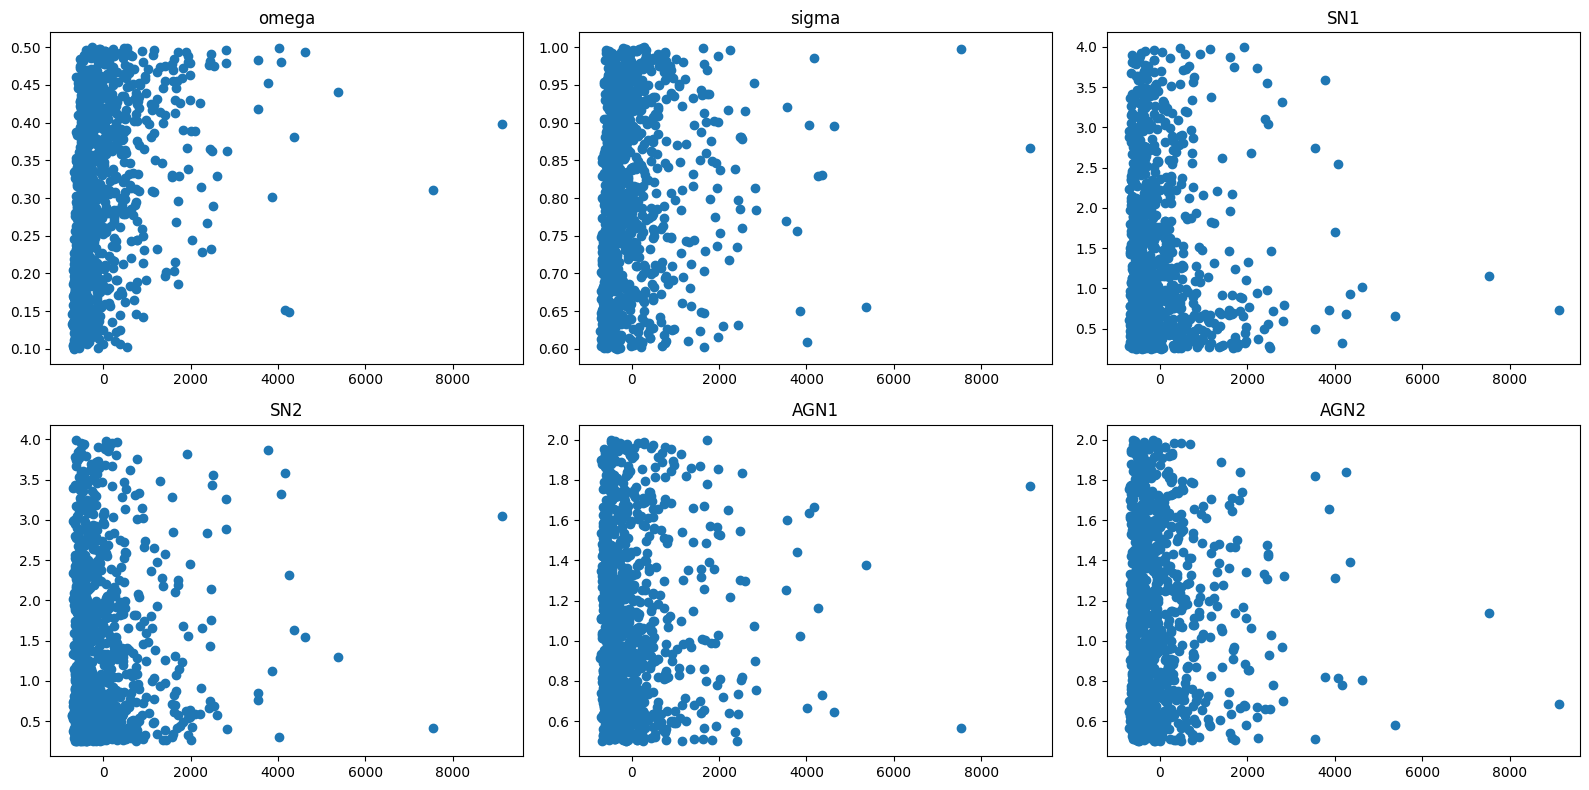

In [34]:
# pc1 real part
norm_pcs = PCA(wph_norm_coeffs_1000,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((norm_pcs[:,0]).real,params['omega'])
axs[0,1].scatter((norm_pcs[:,0]).real,params['sigma'])
axs[0,2].scatter((norm_pcs[:,0]).real,params['SN1'])
axs[1,0].scatter((norm_pcs[:,0]).real,params['SN2'])
axs[1,1].scatter((norm_pcs[:,0]).real,params['AGN1'])
axs[1,2].scatter((norm_pcs[:,0]).real,params['AGN2'])


fig.tight_layout()
fig.show()

remove L and s11

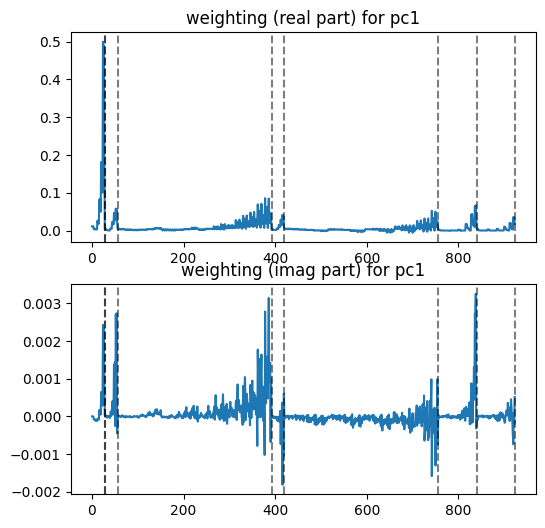

In [35]:
wph_norm_coeffs_900 = wph_norm_coeffs_1000[:,s11_pos:cphase_inv_pos]

norm_weight0 = PCA_weight(wph_norm_coeffs_900, 2)[0]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

axs[0].plot(norm_weight0.real)
axs[1].plot(norm_weight0.imag)

axs[0].set_title('weighting (real part) for pc1')
axs[1].set_title('weighting (imag part) for pc1')

for i in range(0,2):
  #axs[i].axvline(s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c00_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5) # c00_shape=0
  axs[i].axvline(s01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c01_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(s10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(c10_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)
  axs[i].axvline(cphase_inv_pos-s11_pos, linestyle='dashed', color='black', alpha=0.5)


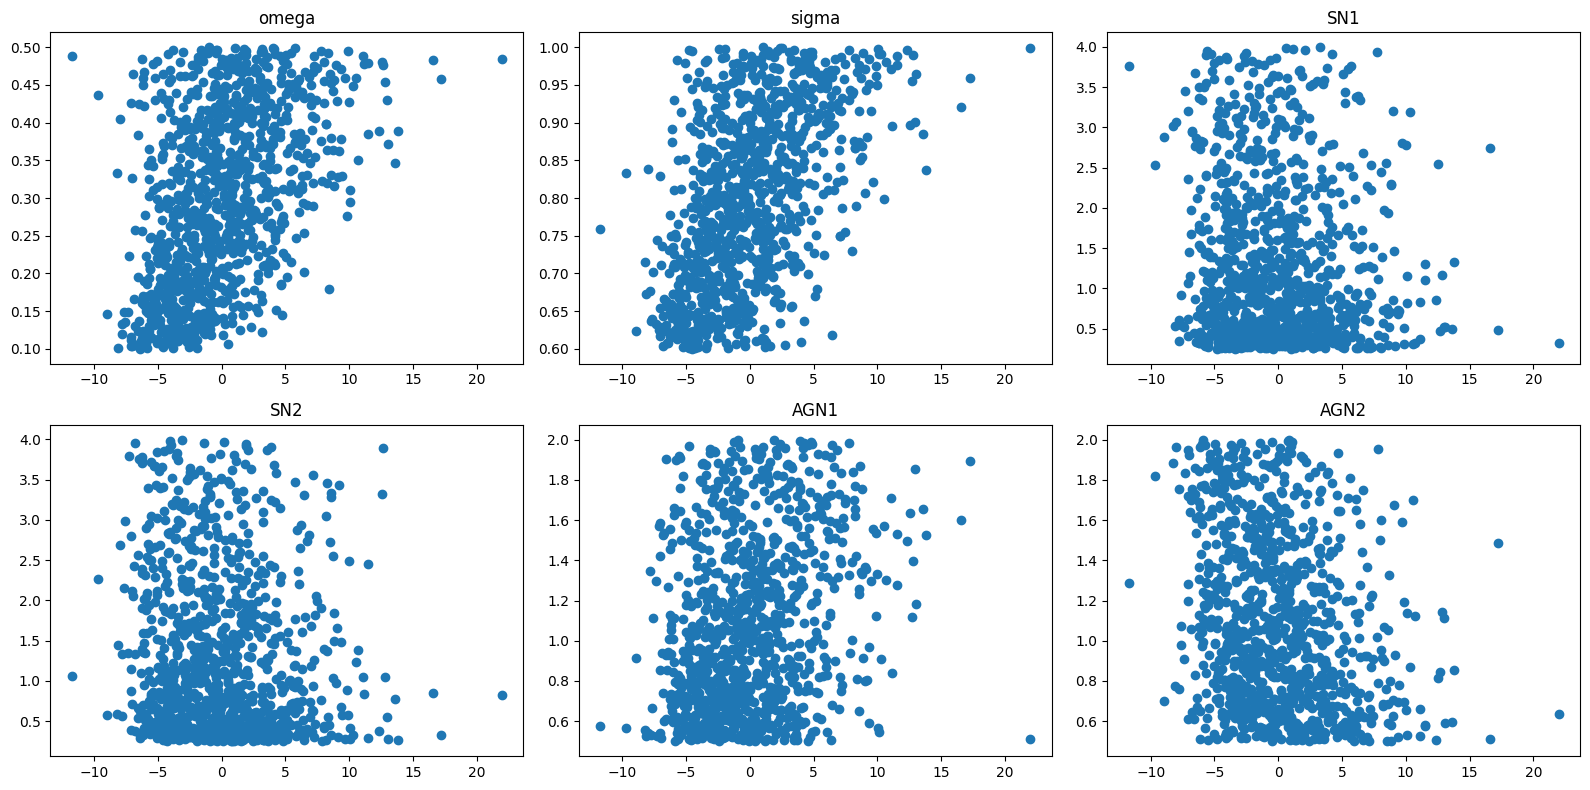

In [36]:
# pc1 real part
norm_pcs_900 = PCA(wph_norm_coeffs_900,2)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega')
axs[0,1].set_title('sigma')
axs[0,2].set_title('SN1')
axs[1,0].set_title('SN2')
axs[1,1].set_title('AGN1')
axs[1,2].set_title('AGN2')

axs[0,0].scatter((norm_pcs_900[:,0]).real,params['omega'])
axs[0,1].scatter((norm_pcs_900[:,0]).real,params['sigma'])
axs[0,2].scatter((norm_pcs_900[:,0]).real,params['SN1'])
axs[1,0].scatter((norm_pcs_900[:,0]).real,params['SN2'])
axs[1,1].scatter((norm_pcs_900[:,0]).real,params['AGN1'])
axs[1,2].scatter((norm_pcs_900[:,0]).real,params['AGN2'])

fig.tight_layout()
fig.show()